# 1. Fourier Spectral Grid

In [1]:
import numpy as np

from scipy.linalg import inv
from scipy.fft import fft, ifft

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Welcome to the course!

The idea behind spectral methods is simple: We decompose gird functions in terms of a complete basis of analytic functions, over a given domain. In this way, any function can be expressed as a (truncated) series of known functions, with numerical coefficients. Then, we can do any manipulation we like (such as differentiation) analytically on the basis functions. The simplest example is the Fourier basis, where we use the basis functions

$$u_k(x) = \exp(i \, k\, x)\, , \quad k = 0, \dots, N - 1,$$

on an equispaced computational grid

$$x_j = \frac{2 \, \pi\,  j}{N}\, , \quad j = 0, \dots, N - 1.$$

We will define the matrix `spectral_basis` as the matrix whose columns are the spectral basis functions evaluated on the grid: $S_{jk} = u_k(x_j)$. This will act as a change-of-basis matrix, that translates any vector in Fourier space to direct space. Its inverse, as we will see later, translates from direct space to Fourier space. We also define `dense basis` as the same basis functions evaluated on a much larger number of points. This matrix will be useful to visualize the grid functions in the continuum, as well as for interpolation outside the computational grid.

In [2]:
N = 16

row = np.arange(N)[:, None]
col = np.arange(N)[None, :]

def aliased_index(k, N):
    return k - N * (k >= (N + 1)//2)

def is_the_same(A, B):
    return np.max(np.abs(A - B)) < 1e-6

spectral_grid  = 2 * np.pi * row / N                    # Trefethen adds 2*pi /N to this grid. I like it this way instead.
dense_grid     = np.linspace(0, 2*np.pi, 1000)[:, None]

spectral_basis = np.exp(1j * aliased_index(col, N) * spectral_grid)
dense_basis    = np.exp(1j * aliased_index(col, N) * dense_grid)

if N % 2 == 0:                                          # Here we remove the imaginary part of the Nyquist mode.
    dense_basis[:, N//2] = dense_basis[:, N//2].real    # This is equivalent to Trefethen's trick in page 19.

## 1.1 Aliasing and the Nyquist frequency

We have to be careful, however, when using a Fourier basis on a discrete grid. Any frequency higher than the so-called Nyquist frequency `N//2` will be completely equivalent to a lower frequency on the grid. Additionally, only the real part of the Nyquist mode survives when evaluated on the grid. The Nyquist mode is the worst nightmare for anyone using spectral methods. 

The function `aliased_index(k, N)` translates a frequency k to its equivalent on the grid. In the cell below, you can experiment with it.


Frequencies on the grid: [ 0  1  2  3  4  5  6  7 -8 -7 -6 -5 -4 -3 -2 -1].



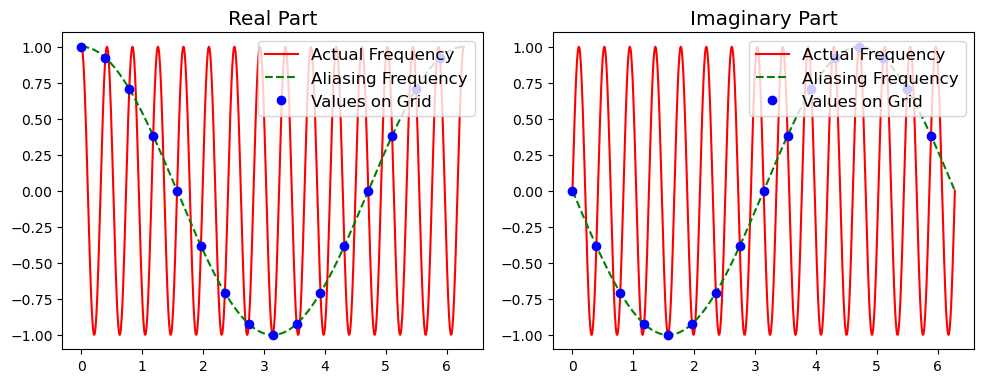

In [3]:
n = 15    # Try values at the Nyquist frequency N//2 and higher.

print(f'\nFrequencies on the grid: {aliased_index(np.arange(N), N)}.\n')

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].set_title('Real Part')
ax[0].plot(dense_grid, np.exp(1j * n * dense_grid).real, 'r-', label = 'Actual Frequency')
ax[0].plot(dense_grid, dense_basis[:, n].real, 'g--', label = 'Aliasing Frequency')
ax[0].plot(spectral_grid, spectral_basis[:, n].real, 'bo', label = 'Values on Grid')
ax[0].legend(loc = 'upper right')
ax[0].set_ylim(-1.1, 1.1)

ax[1].set_title('Imaginary Part')
ax[1].plot(dense_grid, np.exp(1j * n * dense_grid).imag, 'r-', label = 'Actual Frequency')
ax[1].plot(dense_grid, dense_basis[:, n].imag, 'g--', label = 'Aliasing Frequency')
ax[1].plot(spectral_grid, spectral_basis[:, n].imag, 'bo', label = 'Values on Grid')
ax[1].legend(loc = 'upper right')
ax[1].set_ylim(-1.1, 1.1)

plt.tight_layout()
################################################################################

## 1.2 Orthogonality and the Slow Fourier Transform :-)

Here we plot the real and imaginary parts of the `spectral basis` matrix. Notice that the matrix is symmetric, and that it has a central cross of alternating 1's and 0's corresponding to the Nyquist mode.  

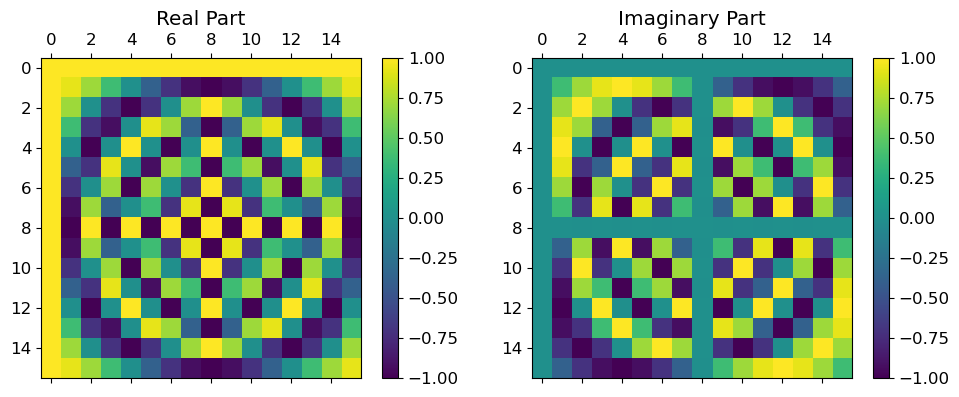

In [4]:
################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].set_title('Real Part')
pt0 = ax[0].matshow(spectral_basis.real)
plt.colorbar(pt0, ax = ax[0])

ax[1].set_title('Imaginary Part')
pt1 = ax[1].matshow(spectral_basis.imag)
plt.colorbar(pt1, ax = ax[1])

plt.tight_layout()
################################################################################

Actually, the inverse of `spectral_basis` is just its complex conjugate. We defined the function `is_the_same` to check that two quantities agree.

True


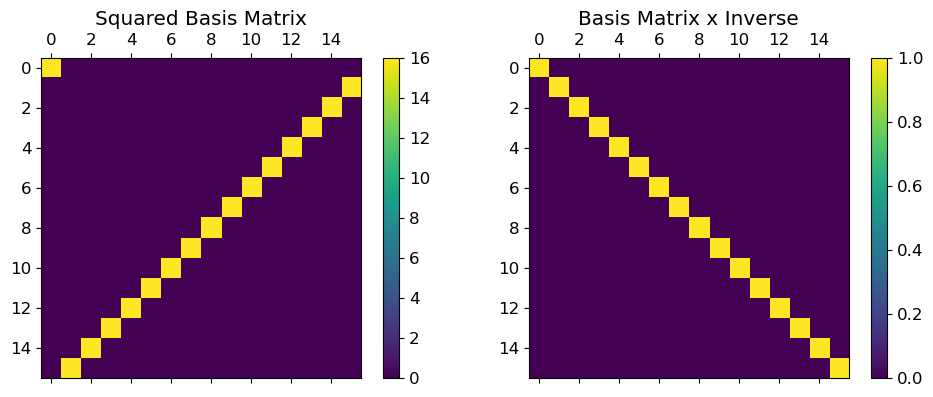

In [5]:
spectral_basis_inv = spectral_basis.conjugate() / N

print(is_the_same(spectral_basis_inv, inv(spectral_basis)))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].set_title('Squared Basis Matrix')
pt0 = ax[0].matshow(np.abs(spectral_basis @ spectral_basis))
plt.colorbar(pt0, ax = ax[0])

ax[1].set_title('Basis Matrix x Inverse')
pt1 = ax[1].matshow(np.abs(spectral_basis @ spectral_basis_inv))
plt.colorbar(pt1, ax = ax[1])

plt.tight_layout()
################################################################################

Since the matrix `spectral_basis_inv` translates from direct space to Fourier space, its multiplycation by a column vector should be equivalent to taking the Fast Fourier Transform (FFT) of such vector. Indeed, we can check that this is the case. This method is, however, much less efficient than the FFT algorithms, as it scales as $\mathcal{O}(N^2)$. FFT algorithms typically scale as $\mathcal{O}(N \log N)$ instead.

In [6]:
f = np.exp(np.sin(spectral_grid))

actual_FFT = fft(f.flatten())
matrix_FFT = N * (spectral_basis_inv @ f).flatten()
is_the_same(actual_FFT, matrix_FFT)

True

## 1.3 The cardinal functions

The cardinal functions $\phi_i(x)$ are extremely important, as they are linear combinations of the basis functions $u_k(x)$ that behave as the Kronecker delta on the grid,

$$\phi_i(x_j) = \delta_{ij}\, .$$

In the case of the Fourier grid, all cardinals are translations of the same function $\phi_i(x) = \phi(x - x_j)$, which depends on the parity of $N$ as

$$\phi_\text{even}(x) = \frac{\sin(N x / 2)}{N \tan (x / 2)} \quad (\text{even } N)\, ,$$

also known as the periodic sinc function, and

$$\phi_\text{odd}(x) = \frac{\sin(N x / 2)}{N \sin (x / 2)} \quad (\text{odd } N)\, .$$

 Using the cardinals, any periodic function $f(x)$ can be spectrally interpolated from its values on the grid, as

$$f(x) \approx \sum_{i = 0}^{N-1} \, \phi_j(x) \, f(x_j)\, .$$

True


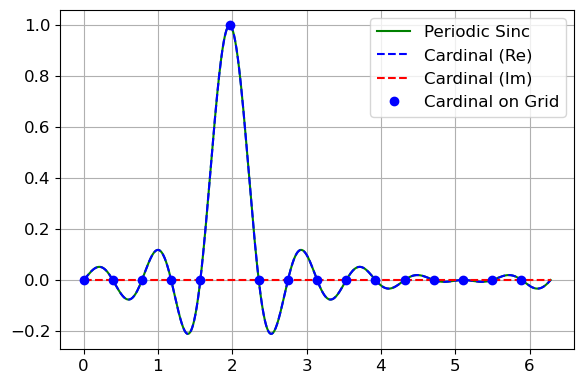

In [7]:
n = 5

def sinc(x, N):
    x0 = (x == 0)
    if N%2 == 0:
        return x0 + np.sin(N * x / 2) / (N * np.tan(x / 2) + x0)
    else:
        return x0 + np.sin(N * x / 2) / (N * np.sin(x / 2) + x0)

spectral_cardinals = np.eye(N)
dense_cardinals    = dense_basis @ spectral_basis_inv

print(is_the_same(sinc(dense_grid - spectral_grid[n], N), dense_cardinals[:, [n]]))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid,    sinc(dense_grid - spectral_grid[n], N), color = 'green', label = 'Periodic Sinc')
ax.plot(dense_grid,    dense_cardinals[:, n].real, 'b--', label = 'Cardinal (Re)')
ax.plot(dense_grid,    dense_cardinals[:, n].imag, 'r--', label = 'Cardinal (Im)')
ax.plot(spectral_grid, spectral_cardinals[:, n], 'bo', label = 'Cardinal on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()
################################################################################

To compute a spectral derivative, we just use the interpolation formula above, but we replace each of the cardinals $\phi_i(x)$ by its derivative $\phi'_i(x)$, as

$$f'(x) \approx \sum_{i = 0}^{N-1} \, \phi'_j(x) \, f(x_j)\, .$$

The operation can be written as the multiplication of a matrix, here called `diff_matrix`, by the column vector containing $f(x_j)$. It is very important to keep in mind that the grid is only capable of storing the real part of the Nyquist mode. Therefore, its derivative must be set to zero "by hand".

True


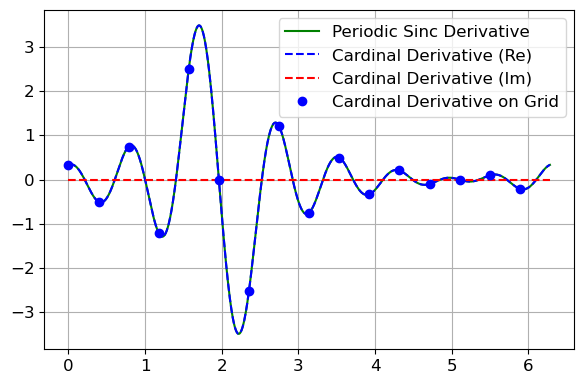

In [8]:
n = 5

def sinc_diff(x, N):
    x0 = (x == 0)
    if N % 2 == 0:
        return 0.5 * np.cos(N * x / 2) / (np.tan(x / 2) + x0) - np.sin(N * x / 2) / (2 * N * np.sin(x / 2)**2 + x0)
    else:
        return 0.5 * np.cos(N * x / 2) / (np.sin(x / 2) + x0) - np.sin(N * x / 2) / (2 * N * np.sin(x / 2) * np.tan(x / 2) + x0)

spectral_basis_diff   = 1j * aliased_index(col, N) * np.exp(1j * aliased_index(col, N) * spectral_grid)
dense_basis_diff      = 1j * aliased_index(col, N) * np.exp(1j * aliased_index(col, N) * dense_grid)

if N % 2 == 0:                                                          #Here we remove the imaginary part of the Nyquist mode.
    spectral_basis_diff[:, N//2] = spectral_basis_diff[:, N//2].real    #This is equivalent to Trefethen's trick in page 19.
    dense_basis_diff[:, N//2]    = dense_basis_diff[:, N//2].real    

diff_matrix          = spectral_basis_diff @ spectral_basis_inv
dense_cardinals_diff = dense_basis_diff @ spectral_basis_inv

print(is_the_same(sinc_diff(dense_grid - spectral_grid[n], N), dense_cardinals_diff[:, [n]]))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid,    sinc_diff(dense_grid - spectral_grid[n], N), color = 'green', label = 'Periodic Sinc Derivative')
ax.plot(dense_grid,    dense_cardinals_diff[:, n].real, 'b--', label = 'Cardinal Derivative (Re)')
ax.plot(dense_grid,    dense_cardinals_diff[:, n].imag, 'r--', label = 'Cardinal Derivative (Im)')
ax.plot(spectral_grid, diff_matrix[:, n].real, 'bo',   label = 'Cardinal Derivative on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()
################################################################################

## 1.4 Fourier Differentiation Matrices and Interpolation

The matrix `diff_matrix` obtained above, and its equivalent for second derivatives, can be computed explicitly by the function `FourierD(N)` defined below. We check explicitly that both matrices agree:

In [9]:
def FourierD(N):
    row = np.arange(N)[:, None]
    col = np.arange(N)[None, :]
    I  = np.eye(N)
    Ic = np.ones((N, N)) - I
    
    x = 2 * np.pi * row / N
    h = (x[1] - x[0])[0]
    
    if N % 2 == 0:
        center = - (N**2 + 2) / 12
        D1 = Ic * 0.5 * (-1)**(row + col) / np.tan(0.5 * ((row - col) * h) + I)
        D2 = Ic * 0.5 * (-1)**(row + col + 1) / np.sin(0.5 * ((row - col) * h) + I)**2 + center * I
    else:
        center = (1 - N**2) / 12
        D1 = Ic * 0.5 * (-1)**(row + col) / np.sin(0.5 * ((row - col) * h) + I)
        D2 = Ic * 0.5 * (-1)**(row + col + 1) / (np.sin(0.5 * ((row - col) * h)) * np.tan(0.5 * ((row - col) * h)) + I) + center * I
    return x, D1, D2

x, D1, D2 = FourierD(N)
is_the_same(D1, diff_matrix)

True

As an example, here we compute the first two spectral derivatives of the function $f(x) = e^{\sin (x)}$ using the differentiation matrices. This function is particularly useful as a test, because it contains components for all the Fourier basis functions. A simpler test with the periodic function $\sin(x)$, for instance, would not be exhaustive as it involves only two of the basis functions.

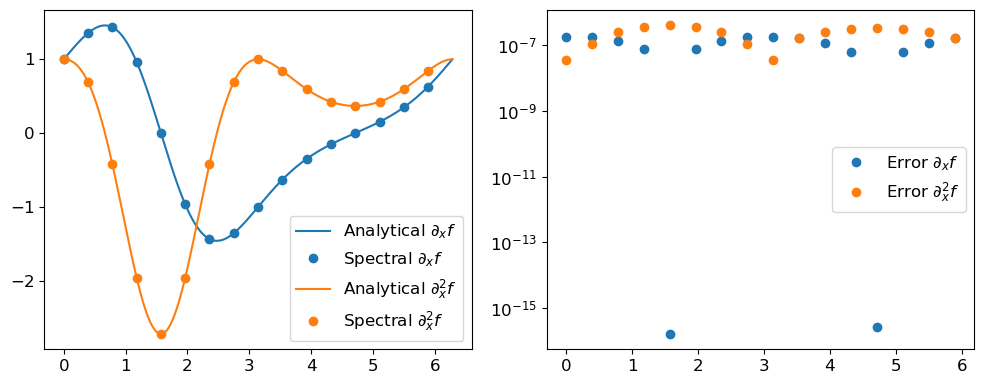

In [10]:
f   = np.exp(np.sin(x))
df  = np.cos(x) * f
ddf = (np.cos(x)**2 - np.sin(x)) * f

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals.real @ df,  label = 'Analytical $\partial_x f$',   color = colors[0])
ax[0].plot(x, D1 @ f, 'o', label = 'Spectral $\partial_x f$', color = colors[0])
ax[0].plot(dense_grid, dense_cardinals.real @ ddf, label = 'Analytical $\partial^2_x f$', color = colors[1])
ax[0].plot(x, D2 @ f, 'o', label = 'Spectral $\partial^2_x f$', color = colors[1])
ax[0].legend(loc = 'lower right')

ax[1].set_yscale('log')
ax[1].plot(x, np.abs(D1 @ f - df),  'o', label = 'Error $\partial_x f$', color = colors[0])
ax[1].plot(x, np.abs(D2 @ f - ddf), 'o', label = 'Error $\partial^2_x f$', color = colors[1])
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################

## 1.5 FFT Differentiation

If we are only interested in extracting derivatives, an efficient method is to use the FFT. We multiply the FFT by the vector of frequencies (times the imaginary unit), and then perform an inverse FFT to get the derivative. 

The vector of frequencies, however, has to consider the effect of aliasing, so any frequency larger than N//2 has to be replaced by its equivalent on the grid. Also, we must set the Nyquist frequency to zero if the order of the derivative is odd. This is because odd derivatives of the Nyquist mode are zero if we only consider their real part.


The frequencies for the first derivative are:  [ 0  1  2  3  4  5  6  7  0 -7 -6 -5 -4 -3 -2 -1].

The frequencies for the second derivative are: [ 0  1  2  3  4  5  6  7 -8 -7 -6 -5 -4 -3 -2 -1].


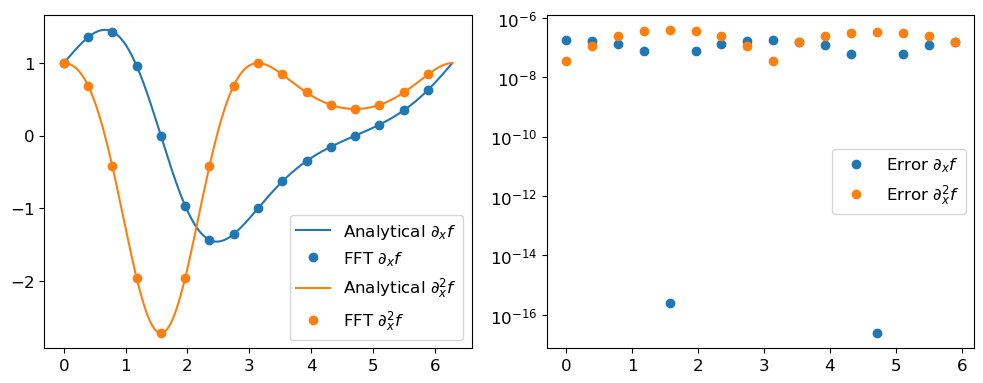

In [11]:
f   = np.exp(np.sin(x))
df  = np.cos(x) * f
ddf = (np.cos(x)**2 - np.sin(x)) * f

freqs1 = aliased_index(np.arange(N), N) 
freqs2 = aliased_index(np.arange(N), N)

if N % 2 == 0:         #Here we kill the derivative of the Nyquist mode.
    freqs1[N//2] = 0   #This is equivalent to Trefethen's trick in page 23.

print(f'\nThe frequencies for the first derivative are:  {freqs1}.')
print(f'\nThe frequencies for the second derivative are: {freqs2}.')

FFT_df  = ifft(1j * freqs1 * fft(f.flatten())).real
FFT_ddf = ifft(- freqs2**2 * fft(f.flatten())).real

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals.real @ df, label = 'Analytical $\partial_x f$',    color = colors[0])
ax[0].plot(x, FFT_df, 'o', label = 'FFT $\partial_x f$', color = colors[0])
ax[0].plot(dense_grid, dense_cardinals.real @ ddf, label = 'Analytical $\partial^2_x f$', color = colors[1])
ax[0].plot(x, FFT_ddf, 'o', label = 'FFT $\partial^2_x f$', color = colors[1])
ax[0].legend(loc = 'lower right')

ax[1].set_yscale('log')
ax[1].plot(x, np.abs(FFT_df - df.flatten()),   'o', label = 'Error $\partial_x f$', color = colors[0])
ax[1].plot(x, np.abs(FFT_ddf - ddf.flatten()), 'o', label = 'Error $\partial^2_x f$', color = colors[1])
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################

## 1.6 Integration

Integration on periodic functions only makes sense if the integral is defined over the whole domain. Indefinite integrals of periodic functions are not necessarily periodic (their constant term becomes linear), so we will not consider them here. 

For definite integrals over the whole domain (also called quadratures), we only need to average the function values over the grid points, and then multiply by 2$\pi$. This happens because all the spectral functions with nonzero frequency average exactly to zero on the grid, as shown below.

In [12]:
np.abs(np.mean(spectral_basis, axis = 0))

array([1.00000000e+00, 3.53815554e-17, 4.90653893e-17, 3.97459940e-16,
       3.85786410e-16, 3.18074688e-16, 3.68807270e-16, 2.18464989e-16,
       2.83276945e-16, 2.18464989e-16, 3.68807270e-16, 3.18074688e-16,
       3.85786410e-16, 3.97459940e-16, 4.90653893e-17, 3.53815554e-17])

Here we use this technique to perform the integral

$$\int_0^{2\pi} e^{\sin (x)} dx \approx 7.9549$$

In [13]:
CorrectIntegral       = 7.9549265210128452728
TrapezoidRuleIntegral = 2 * np.pi * np.mean(f)

is_the_same(CorrectIntegral, TrapezoidRuleIntegral)

True